In [20]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable           Type              Data/Info
----------------------------------------------
Tsam               float64           0.5
dvMathcalP         LinearIOSystem    <LinearIOSystem>: sys[115<...>[[0. 0.]\n     [0. 0.]]\n
extMathcalP        LinearIOSystem    <LinearIOSystem>: sys[114<...> [0. 0.]\n     [0. 0.]]\n
fullOrder          int               100
hsvDvMathcalP      ndarray           100: 100 elems, type `float64`, 800 bytes
hsvExtMathcalP     ndarray           100: 100 elems, type `float64`, 800 bytes
mathcalC           StateSpace        A = [[-100.]]\n\nB = [[10<...>.081]]\n\nD = [[0.101]]\n
mathcalP_cb        LinearIOSystem    <LinearIOSystem>: sys[6]\<...>[[0. 0.]\n     [0. 0.]]\n
overlineMathcalC   StateSpace        A = [[0.]]\n\nB = [[0.1]]<...>= [[0.101]]\n\ndt = 0.5\n
reducOrder         int               8
truncDvMathcalP    LinearIOSystem    <LinearIOSystem>: sys[117<...>[[0. 0.]\n     [0. 0.]]\n
truncExtMathcalP   LinearIOSystem    <LinearIOSystem>: sys[116<...> [

In [21]:
import numpy
import sympy
import scipy
import control
import matplotlib as mpl
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

In [24]:
# Loop parameters
w_lim=[10,100]
w_steps = 50
cutoffs = numpy.linspace(w_lim[0],w_lim[1],w_steps)

samp_lim = [0.2,0.5]
samp_steps = 10
samplings = numpy.linspace(samp_lim[0],samp_lim[1],samp_steps)

In [25]:
#Create plot
 
s = control.TransferFunction.s
small_gain_FOM = numpy.empty((samp_steps,w_steps))*0
small_gain_ROM = numpy.empty((samp_steps,w_steps))*0

for i in range(samp_steps-1,-1,-1):
    for j in range(w_steps-1,-1,-1):
        Tsam = samplings[i]
        cutoff = cutoffs[j]
        # Lag Compensator
        lagK = 1
        lagZ = cutoff*10
        lagP = cutoff
        lagCompNum = (1+lagP) * numpy.array([1,lagZ]) * lagK
        lagCompDen = (1+lagZ) * numpy.array([1,lagP]) 
        lagComp = control.tf2ss(lagCompNum,lagCompDen)
        # Creating controller
        Kp = 0
        mathcalC = control.parallel(lagComp, Kp)
        # Norm operator Delta
        normInfDelta = 2*Tsam/numpy.pi
        # Discretizing controller and computing norm of widetildeMathcalCs
        overlineMathcalC = control.sample_system(mathcalC, Tsam, 'zoh')
        mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
        tfMathcalCPrime = control.ss2tf(mathcalCPrime)
        normInfWidetildeMathcalCs = normInfDelta * ControlUtils.hinfnorm(mathcalC) \
                                + normInfDelta * ControlUtils.hinfnorm(s * tfMathcalCPrime) * normInfDelta \
                                + ControlUtils.hinfnorm(tfMathcalCPrime) * normInfDelta 
        #######################################################################                        
        # Creating closed-loop
        # Controller matrices
        Ac = mathcalC.A
        Bv = mathcalC.B
        Cw = mathcalC.C
        Dw = mathcalC.D
        #######################################################################
        # FOM extended plant
        Ap = extMathcalP.A
        Bw = extMathcalP.B[:,0:1]
        Bu = extMathcalP.B[:,1:2]
        Cv = extMathcalP.C[0:1,:]
        Cy = extMathcalP.C[-1:,:]
        Dv = extMathcalP.D[0:1,:]
        Dy = extMathcalP.D[-1:,:]
        #######################################################################
        # Closed-loop with FOM Extended Plant
        extAcl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                                    numpy.column_stack( [ Bv@Cv, Ac ] )
                                    ] )
        extBcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                                    ] )
        extCcl = numpy.row_stack( [ numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                                    numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        extDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                                    numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                                    numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                                    ] )
        extMathcalPcl = control.ss(extAcl,extBcl,extCcl,extDcl)
        #######################################################################
        # ROM extended plant
        truncExtAp = truncExtMathcalP.A
        truncExtBw = truncExtMathcalP.B[:,0:1]
        truncExtBu = truncExtMathcalP.B[:,1:2]
        truncExtCv = truncExtMathcalP.C[0:1,:]
        truncExtCy = truncExtMathcalP.C[-1:,:]
        truncExtDv = truncExtMathcalP.D[0:1,:]
        truncExtDy = truncExtMathcalP.D[-1:,:]
        # Closed-loop with ROM Extended Plant
        truncExtAcl = numpy.row_stack( [ numpy.column_stack( [ truncExtAp + truncExtBw@Dw@truncExtCv, truncExtBw@Cw ] ),
                                    numpy.column_stack( [ Bv@truncExtCv, Ac ] )
                                    ] )
        truncExtBcl = numpy.row_stack( [ numpy.column_stack([truncExtBw, truncExtBu]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (Ac.shape[0],truncExtBu.shape[1]) ) ] )
                                    ] )
        truncExtCcl = numpy.row_stack( [ numpy.column_stack( [ truncExtCv, numpy.zeros( (truncExtCv.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ truncExtCv@truncExtAp + truncExtCv@truncExtBw@Dw@truncExtCv, truncExtCv@truncExtBw@Cw ] ),
                                    numpy.column_stack( [ truncExtCy, numpy.zeros( (truncExtCy.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        truncExtDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (truncExtCv.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCv.shape[0],truncExtBu.shape[1]) ) ] ),
                                    numpy.column_stack( [ truncExtCv@truncExtBw , truncExtCv@truncExtBu] ),
                                    numpy.column_stack( [ numpy.zeros( (truncExtCy.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCy.shape[0],truncExtBu.shape[1]) ) ] )
                                    ] )
        truncExtMathcalPcl = control.ss(truncExtAcl,truncExtBcl,truncExtCcl,truncExtDcl)
        #######################################################################
        approxErrorExtMathcalPcl = extMathcalPcl-truncExtMathcalPcl
        #######################################################################
        # Computing norms for small-gain stability condition
        gamma_tildew_dv = ControlUtils.hinfnorm(extMathcalPcl[1,0])
        epsilon_tildew_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[1,0])
        gamma_dv_tildew = normInfWidetildeMathcalCs
        #######################################################################
        small_gain_argument_FOM = gamma_tildew_dv*gamma_dv_tildew
        small_gain_FOM[i,j] = small_gain_argument_FOM
        # display(Math('\\lVert \\mathcal{P}_{ext}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' \
            # + str(small_gain_argument_FOM) ))
        
        small_gain_argument_ROM = (gamma_tildew_dv+epsilon_tildew_dv)*gamma_dv_tildew
        small_gain_ROM[i,j] = small_gain_argument_ROM
        # display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' \
            # + str(small_gain_argument_ROM) ))
        print("Small-gain condition. Tsam[%d]: %2.3f, cutoff[%d]: %3.5f, FOM: %2.5f, ROM: %2.5f"%(i,Tsam,j,cutoff,small_gain_argument_FOM,small_gain_argument_ROM))
        
        if(small_gain_ROM[i,j]<1):
            continue

Small-gain condition. Tsam[9]: 0.500, cutoff[49]: 100.00000, FOM: 3.50165, ROM: 3.57024
Small-gain condition. Tsam[9]: 0.500, cutoff[48]: 98.16327, FOM: 3.44184, ROM: 3.50926
Small-gain condition. Tsam[9]: 0.500, cutoff[47]: 96.32653, FOM: 3.38203, ROM: 3.44828
Small-gain condition. Tsam[9]: 0.500, cutoff[46]: 94.48980, FOM: 3.32223, ROM: 3.38731
Small-gain condition. Tsam[9]: 0.500, cutoff[45]: 92.65306, FOM: 3.26243, ROM: 3.32634
Small-gain condition. Tsam[9]: 0.500, cutoff[44]: 90.81633, FOM: 3.20263, ROM: 3.26537
Small-gain condition. Tsam[9]: 0.500, cutoff[43]: 88.97959, FOM: 3.14284, ROM: 3.20441
Small-gain condition. Tsam[9]: 0.500, cutoff[42]: 87.14286, FOM: 3.08306, ROM: 3.14346
Small-gain condition. Tsam[9]: 0.500, cutoff[41]: 85.30612, FOM: 3.02328, ROM: 3.08251
Small-gain condition. Tsam[9]: 0.500, cutoff[40]: 83.46939, FOM: 2.96350, ROM: 3.02156
Small-gain condition. Tsam[9]: 0.500, cutoff[39]: 81.63265, FOM: 2.90374, ROM: 2.96062
Small-gain condition. Tsam[9]: 0.500, cuto

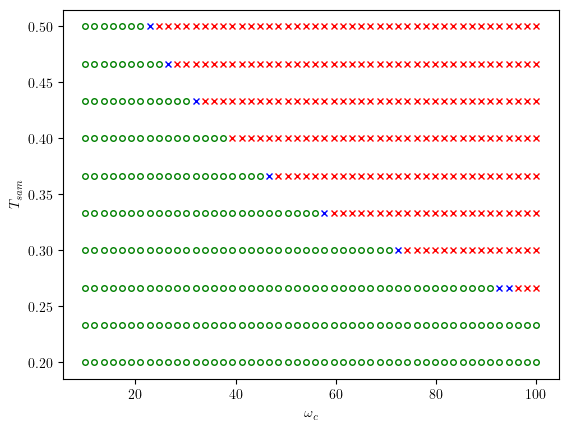

In [26]:
for i in range(samp_steps):
    for j in range(w_steps):
        Tsam = samplings[i]
        cutoff = cutoffs[j]
        
        if(small_gain_ROM[i,j]<1):
            plt.plot(cutoff, Tsam, marker="o", markersize=4, markerfacecolor='none', markeredgecolor='g')
        elif(small_gain_FOM[i,j]<1):
            plt.plot(cutoff, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
        else:
            plt.plot(cutoff, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
        # if(small_gain_FOM[i,j]<1 and small_gain_ROM[i,j]>1):
        #     plt.plot(cutoff, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
        #     # plt.plot(cutoff, Tsam, marker="o", markersize=7, markerfacecolor='none', markeredgecolor='b')
        # else:
        #     if(small_gain_ROM[i,j]<1):
        #         plt.plot(cutoff, Tsam, marker="o", markersize=4, markerfacecolor='b', markeredgecolor='g')
        #     else:
        #         # plt.plot(cutoff, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
        #         if(small_gain_FOM[i,j]<1):
        #             plt.plot(cutoff, Tsam, marker="o", markersize=7, markerfacecolor='none', markeredgecolor='g')
        #         else:
        #             plt.plot(cutoff, Tsam, marker="o", markersize=7, markerfacecolor='none', markeredgecolor='r')
            
plt.ylabel('$T_{sam}$')
plt.xlabel('$\\omega_c$')
plt.show()

In [ ]:
%store -d mathcalC overlineMathcalC Tsam
%store mathcalC overlineMathcalC Tsam

Stored 'mathcalC' (StateSpace)
Stored 'overlineMathcalC' (StateSpace)
Stored 'Tsam' (float64)
